# Multimodal Meme Sentiment Analyzer
In order for AI to become a more effective tool for detecting hate speech, it must be able to understand content the way people do: holistically. When viewing a meme, for example, we don’t think about the words and photo independently of each other; we understand the combined meaning together. This is extremely challenging for machines, however, because it means they can’t just analyze the text and the image separately. They must combine these different modalities and understand how the meaning changes when they are presented together.

This is a multimodal classifier that analyzes memes to predict their sentiment using both image and text data. Memes are a unique form of communication that often require the combination of visual and textual elements to understand their sentiment.

In [2]:
# Package Installation 
!pip install torch torchvision transformers pandas scikit-learn seaborn

Defaulting to user installation because normal site-packages is not writeable


### Import Necessary Libraries
This block imports all required libraries for:
- Handling datasets, images, and file processing.
- Deep learning models (ResNet and BERT).
- Data transformations, tokenization, and visualization.


In [3]:
# Required Imports
import os
import zipfile
import pandas as pd
import torch
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


### Meme Image Handling 


In [4]:
# Increase image pixel limit to avoid decompression bomb errors
Image.MAX_IMAGE_PIXELS = None  

# Define paths
zip_file = "meme_collection.zip"
extraction_dir = "/work2/10580/mk43275/stampede3/meme_collection"

# Extract ZIP file (if needed still - ran it a few times)
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(extraction_dir)

# Identify meme directory
meme_dir = extraction_dir
subfolders = [f for f in os.listdir(meme_dir) if os.path.isdir(os.path.join(meme_dir, f))]

if len(subfolders) > 0:
    for subfolder in subfolders:
        subfolder_path = os.path.join(meme_dir, subfolder)
        num_images = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
        if num_images > 0:
            meme_dir = subfolder_path
            print(f"Adjusted meme_dir: Images found in {meme_dir}")
            break


Adjusted meme_dir: Images found in /work2/10580/mk43275/stampede3/meme_collection/meme_collection


### Load & Normalizing Annotations > renaming image files to match

In [5]:
# Load and normalize annotations CSV
annotations_file = "/work2/10580/mk43275/stampede3/annotations.csv"
annotations_df = pd.read_csv(annotations_file)

annotations_df["filename"] = (
    annotations_df["filename"]
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Rename files in `meme_collection` to match `annotations.csv`
for filename in os.listdir(meme_dir):
    corrected_filename = filename.strip().lower().replace(" ", "_")
    old_path = os.path.join(meme_dir, filename)
    new_path = os.path.join(meme_dir, corrected_filename)

    if old_path != new_path:
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} -> {corrected_filename}")

### Data Split / Tokenizing Text / Image Transformation

In [6]:
# Split dataset
test_df = annotations_df.iloc[:75]
train_df = annotations_df.iloc[75:]

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["Label"])
test_labels = label_encoder.transform(test_df["Label"])

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def text_pipeline(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        truncation=True,
        max_length=50,
        padding="max_length",
        return_tensors="pt",
        return_attention_mask=True,
    )
    return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


### Dataset Class
Handling:
- Loading images & text descriptions
- Applying transformations
- Return formatted inputs for training

In [7]:
# Custom Dataset Class
class MemeDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]["filename"]
        img_path = os.path.join(self.img_dir, img_name)

        if not os.path.exists(img_path):
            print(f"Image not found: {img_name}. Using blank image.")
            image = Image.new("RGB", (224, 224), color="white")
        else:
            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"Error loading {img_name}: {e}. Using blank image.")
                image = Image.new("RGB", (224, 224), color="white")

        if self.transform:
            image = self.transform(image)

        text = self.dataframe.iloc[idx]["Description"]
        input_ids, attention_mask = text_pipeline(text)

        label = label_encoder.transform([self.dataframe.iloc[idx]["Label"]])[0]

        return image, input_ids, attention_mask, label

# Custom collate function
def collate_fn(batch):
    images, input_ids, attention_masks, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    return images, input_ids, attention_masks, labels


### DataLoaders for Train & Test
- collate func for padding seq & batch processing

In [8]:
# create DataLoaders
batch_size = 32
train_dataset = MemeDataset(train_df, meme_dir, transform=image_transform)
test_dataset = MemeDataset(test_df, meme_dir, transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ensure device compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    print("Warning: CUDA is not available, training will run on CPU.")


### Multi-Modal Model 
**Takes 2 inputs:**
- Images (process with ResNet)
- Text (process with BERT)
then it combines both and predicts class

*Why ResNet*
- it's a good image feature extractor
- convolutional layers detect patterns in memes

*Freezing layers*
- speed up training 

*Why BERT*
- pretrained on huge text corpora
- freeze all layers except last for meme-specific learning for text

*Fusion Layer*
- concatenating image & text
- combined features passed to fully connected layer for classification

In [9]:
# nn architecture
class MultiModalModel(nn.Module):
    def __init__(self, num_classes=3, embed_dim=768):
        super(MultiModalModel, self).__init__()
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for param in self.cnn.parameters():
            param.requires_grad = False  

        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 512)

        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")
        for param in self.text_encoder.parameters():
            param.requires_grad = False  

        for param in self.text_encoder.encoder.layer[-1].parameters():
            param.requires_grad = True

        self.fc1 = nn.Linear(512 + embed_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, image, input_ids, attention_mask):
        img_features = self.cnn(image)
        text_output = self.text_encoder(input_ids, attention_mask=attention_mask)
        text_features = text_output.last_hidden_state[:, 0, :]
        combined = torch.cat((img_features, text_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, & Optimizer
model = MultiModalModel(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LR Scheduler lowers lr after 5 epochs to prevent overfit
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [10]:
# Check for GPU again - debug
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    print("Warning: CUDA is not available, training will run on CPU.")

model = MultiModalModel(num_classes=len(label_encoder.classes_)).to(device)

# Adjust learning rate for CPU training (smaller batch sizes require lower LR)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train for 25 epochs \
num_epochs = 25
loss_threshold = 0.3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, input_ids, attention_mask, labels in train_loader:
        images, input_ids, attention_mask, labels = (
            images.to(device), 
            input_ids.to(device), 
            attention_mask.to(device), 
            labels.to(device)
        )

        optimizer.zero_grad()

        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    if epoch_loss < loss_threshold:
        print("Loss threshold reached. Stopping early.")
        break


Epoch [1/25], Loss: 1.0928
Epoch [2/25], Loss: 0.8231
Epoch [3/25], Loss: 0.6614
Epoch [4/25], Loss: 0.6156
Epoch [5/25], Loss: 0.5584
Epoch [6/25], Loss: 0.4841
Epoch [7/25], Loss: 0.5025
Epoch [8/25], Loss: 0.4154
Epoch [9/25], Loss: 0.3845
Epoch [10/25], Loss: 0.3112
Epoch [11/25], Loss: 0.2514
Loss threshold reached. Stopping early.


In [11]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

# Disable gradient calculations for faster inference
with torch.no_grad():
    for images, input_ids, attention_mask, labels in test_loader:
        images, input_ids, attention_mask, labels = (
            images.to(device), 
            input_ids.to(device), 
            attention_mask.to(device), 
            labels.to(device)
        )
        
        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = label_encoder.classes_

Test Accuracy: 0.5733

Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.76      0.58        17
     neutral       0.73      0.51      0.60        47
    positive       0.43      0.55      0.48        11

    accuracy                           0.57        75
   macro avg       0.54      0.61      0.55        75
weighted avg       0.62      0.57      0.58        75



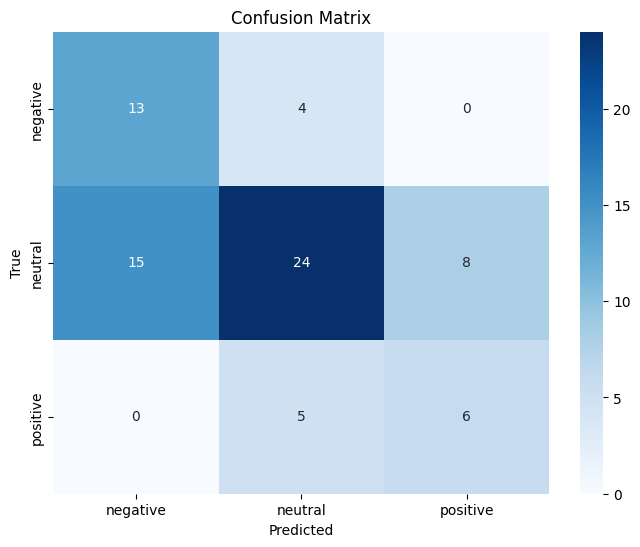

In [12]:
# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Takeaways:
- The model achieved **57.33% accuracy**, meaning it correctly predicted around **57%** of test samples.
- **Neutral class had the highest precision (0.73)** but low recall (0.51), meaning it was confidently predicted but often misclassified.
- **Negative class had the best recall (0.76)**, meaning most negatives were correctly identified.
- **Positive class struggled the most**, with **only 6 correct predictions out of 11**.

### Need improvements
- **Add more variety?**: Many were labeled as negative.
- **Poor performance on the positive class**: The model struggles to differentiate it from neutral.
- **Possible class imbalance**: If there are fewer positive samples, the model may not learn to recognize them well.

### Next steps
- **Fine-tune more layers in BERT** instead of freezing most layers.
- **Unfreeze some convolutional layers in ResNet** for better meme-specific feature extraction.
- **Increase training data** for the positive class through **data augmentation**.
- **Adjust learning rate and optimizer** (try `AdamW` instead of `Adam`).



## New Attempt

###  **1. More BERT Fine-Tuning**
- **unfreeze the last 3 layers** of BERT.
- allows the model to adapt **text embeddings more effectively** to memes.

### **2. More Trainable ResNet Layers**
- **unfreeze the last 2 bottleneck blocks** (layer4 in ResNet-50).
- enables the model to learn **meme-specific image features**.

### **3. Changed Optimizer to AdamW**
- **AdamW (better for transformer-based models)**.
- AdamW includes **weight decay**, improving **generalization and reducing overfitting**.

### **4. Increased Training Epochs**
- More epochs **allow better fine-tuning**, especially with newly unfrozen layers.


Epoch [1/35], Loss: 0.2359
Loss threshold reached. Stopping early.
Updated Test Accuracy: 0.5733

Updated Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.71      0.55        17
     neutral       0.73      0.51      0.60        47
    positive       0.47      0.64      0.54        11

    accuracy                           0.57        75
   macro avg       0.55      0.62      0.56        75
weighted avg       0.62      0.57      0.58        75



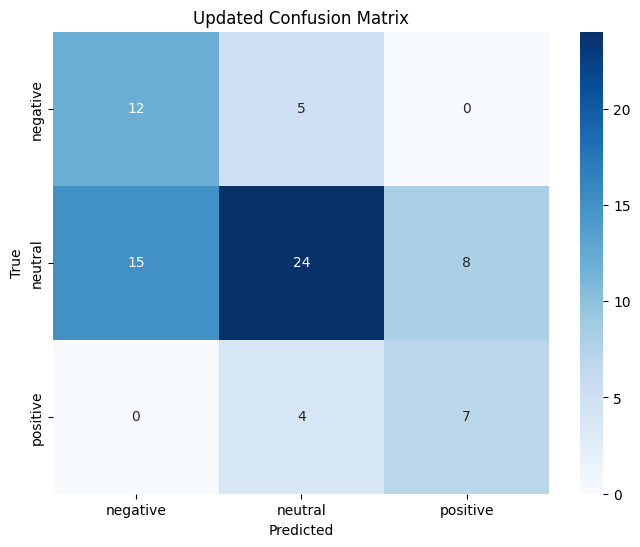

In [13]:
# Unfreeze the last 3 layers of BERT instead of just the last one
for param in model.text_encoder.encoder.layer[-3:].parameters():
    param.requires_grad = True

# Unfreeze some ResNet layers (last 2 bottleneck blocks)
for param in list(model.cnn.layer4.parameters()):
    param.requires_grad = True

# Use AdamW (better for fine-tuning transformers)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Train for more epochs to allow better fine-tuning
num_epochs = 35

# Re-run the training loop with updated settings
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, input_ids, attention_mask, labels in train_loader:
        images, input_ids, attention_mask, labels = (
            images.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )

        optimizer.zero_grad()

        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    if epoch_loss < loss_threshold:
        print("Loss threshold reached. Stopping early.")
        break

# Evaluate the model again after training
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, input_ids, attention_mask, labels in test_loader:
        images, input_ids, attention_mask, labels = (
            images.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )

        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Recalculate accuracy and classification report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Updated Test Accuracy: {accuracy:.4f}")

print("\nUpdated Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Plot updated confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Updated Confusion Matrix")
plt.show()


oops threshold was reached after 1 epoch! 
rerun with new threshold

- **Test accuracy remains at 57.33%**, meaning the adjustments did not significantly change overall performance.
- **Loss threshold was reached after just 1 epoch**, stopping training too early.
- **Negative class recall dropped slightly (0.76 to 0.71)**, meaning fewer negatives were correctly classified.
- **Positive class recall improved (0.55 to 0.64)**, suggesting better recognition of positive samples.
- **Neutral class remains the most misclassified**, with 15 samples incorrectly labeled as negative.
